This assignment is a modified version of [Stanford's CS231n](http://cs231n.stanford.edu/) course materials.

[Stanford's CS231n lecture notes](https://cs231n.github.io/) will be a very useful reference for this assignment.

This notebook is designed for running on linux, for easily running the bash command with wget and other library. You are encourage to run the assignment on colab.

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'vietai/assignments/assignment3/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/core/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

If you are running the assignment on your local machine, please execute this setup cell instead.

In [ ]:
# %cd core/datasets/
# !bash get_datasets.sh
# %cd ../..

# What is Image Captioning? 🤔
Image Captioning is the task of describing the content of an image in words. This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence. The most popular benchmarks are nocaps and COCO, and models are typically evaluated according to a BLEU or CIDER metric.
(ref: [paperswithcode](https://paperswithcode.com/task/image-captioning))

### **Example**
<img src="https://drive.google.com/uc?id=1_lL9Zv-1IN4kKah2h8rQJbtKIzlh1-IP"/>

# What you will do in this assignment? 😤

There are three primary tasks:

- Implementing Image Captioning with LSTMs.
- Implementing Image Captioning with Transformers.
- Providing answers to inline questions.

As a reference and introduction, the code for Image Captioning with RNNs has been provided for you.

# Image Captioning with RNNs
In this exercise, you will be provided with the opportunity to implement vanilla Recurrent Neural Networks and understand how they can be used to train a model capable of generating unique captions for images. This task is categorized as a one-to-many sequence processing task in RNN.

This figure is referenced from: *Karpathy et al., “Deep Visual-Semantic Alignments for Generating Image Descriptions,” CVPR 2015; figure copyright IEEE, 2015.
Reproduced here for educational purposes.*

<img src="https://drive.google.com/uc?id=1sduar8Rv0CeqjRYqXnUm1WH5OSV8W8oQ" width="800" height="500"/>


As depicted in the figure, the Captioning model comprises two primary components:

- The 1<sup>st</sup> part, **Convolutional Neural Network (CNN)**: This section serves as an encoder, transforming image information into `features` that our model can comprehend and then feeding them into the 2<sup>nd</sup> part.

- The 2<sup>nd</sup> part, **Recurrent Neural Network (RNN)**: This part takes the embedded `features` and inputs them into the initial node of the `hidden state` for the decoder to commence decoding. It triggers decoding with a `<START>` special token and concludes with `<END>` to signify the end of decoding.

For this assignment, the 1<sup>st</sup> part has already been prepared (detailed in the **Image features** section), and we will proceed to implement the 2<sup>nd</sup> part with detailed instructions.

# Configurations

In [3]:
# Setup cell.
import numpy as np
import matplotlib.pyplot as plt
import time

from core.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from core.rnn_layers import *
from core.captioning_solver_transformer import CaptioningSolverTransformer
from core.captioning_solver import CaptioningSolver
from core.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from core.image_utils import image_from_url
from core.utils import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# COCO Dataset
For this exercise, we will use the 2014 release of the [COCO dataset](https://cocodataset.org/), a standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

You can load all of the COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `core/coco_utils.py`. Run the following cell to do so:

In [4]:
# Load COCO data from disk into a dictionary.
# We'll work with dimensionality-reduced features for the remainder of this assignment,
# but you can also experiment with the original features on your own by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/My Drive/fodl02-assignment02-pphuc/core/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Inspect the Data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `cs231n/coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

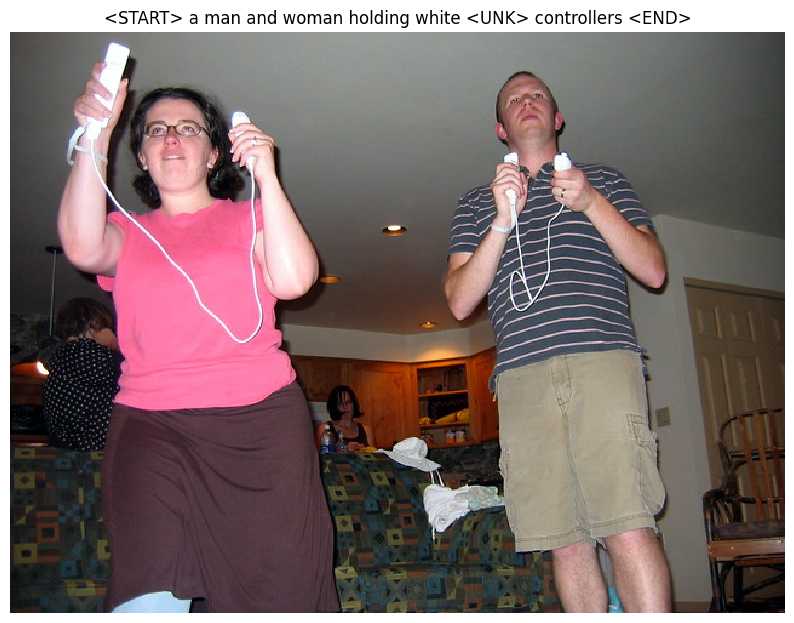

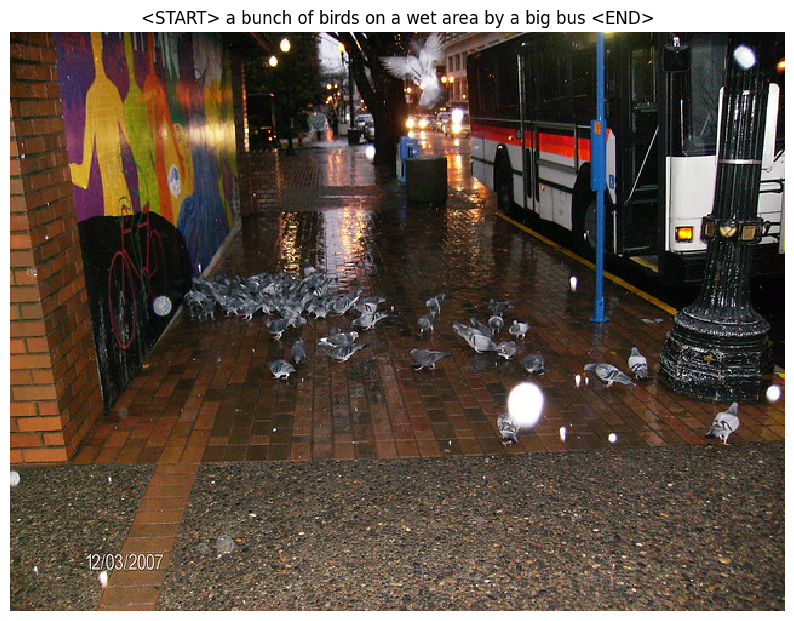

In [5]:
# Sample a minibatch and show the images and captions.
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

### Image features

**Image features.** We have preprocessed the data and extracted features for you already. For all images, we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet, and these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5`. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512 using Principal Component Analysis (PCA), and these features are stored in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`. The raw images take up nearly 20GB of space so we have not included them in the download. Since all images are taken from Flickr, we have stored the URLs of the training and validation images in the files `train2014_urls.txt` and `val2014_urls.txt`. This allows you to download images on-the-fly for visualization.

The `FC7 layer` of VGG16 extracts a 4096-dimensional `vector representation` of the input image. This vector representation contains `high-level information` about the image, such as the objects that are present in the image, the relationships between the objects, and the overall scene.

This figure illustrates the VGG-16 architecture, which inputs the image, and the features extracted from the `FC7 layer`. It helps you grasp an idea how the Convolutional Neural Network process works. Additionally, please note the formula for `h` as you will encounter it again during the implementation of the RNN.

<img src="https://drive.google.com/uc?id=1KsJem1T9M1EbAqSb7O-SxnVQQV8nCs96" width="800" height="500"/>

In [6]:
print(features)

[[ 35.2646       1.9553003   -1.9430064  ...   0.5604166    1.2905662
   -0.32468492]
 [ -7.1964045   19.442497    11.95066    ...  -1.2133611   -0.63827735
   -0.33110774]
 [  3.6220045  -24.418709     7.8015566  ...   0.42619538   1.7815285
   -0.11142278]]


#### IQ1: Inline Question 1 (05 points)
Why they use the VGG-16 network pretrained on ImageNet dataset instead of training from scratch on this image captioning dataset?

**A.** Training from scratch is faster and more efficient.

**B.** Pretrained VGG-16 on ImageNet provides valuable feature extraction capabilities.

**C.** Training from scratch improves captioning performance significantly.

**Your answer:**

Why they use the vector representation of FC-4096 (FC7) layer instead of the final layer FC-1000 (FC8)?

**A.** FC-4096 is a shallower layer and thus computationally less intensive.

**B.** FC-1000 offers features that are more transferable to diverse tasks, while FC-4096 is designed for classifying purpose.

**C.** FC-1000 is designed for classifying purpose, while FC-4096 offers features that are more transferable to diverse tasks.

**Your answer:**

### Captions

**Captions.** Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `core/coco_utils.py` to convert NumPy arrays of integer IDs back into strings.

In [7]:
# Take first caption in list of captions
caption = captions[0]

print("Encoded caption (list of ID): ", caption)
print("Caption: ", decode_captions(caption, data['idx_to_word']))

Encoded caption (list of ID):  [  1   4  23   9   4 435  73 856  10 156   2   0   0   0   0   0   0]
Caption:  <START> a woman with a purple snow coat and skis <END>


### Tokens

**Tokens.** There are a couple special tokens that we add to the vocabulary, and we have taken care of all implementation details around special tokens for you. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens.

As you can see in the example, `special_token` are the first 4 elements from `data['idx_to_word']`:
- `<NULL>` has index 0 in the array `special_token`
- `<START>` has index 1
- `<END>` has index 2
- `<UNK>` has index 3

Looking at the encoded caption, you can see `1` at the start, however the end is not `2`, because there are five `0`, functions as **padding** for the same legths among data items in minibatchs.

In [8]:
# Take first caption in list of captions
caption = captions[0]

special_token = data['idx_to_word'][:4]
print("Encoded caption (list of ID): ", caption)
print("Caption: ", decode_captions(caption, data['idx_to_word']))

print("Special token: ", special_token)

Encoded caption (list of ID):  [  1   4  23   9   4 435  73 856  10 156   2   0   0   0   0   0   0]
Caption:  <START> a woman with a purple snow coat and skis <END>
Special token:  ['<NULL>', '<START>', '<END>', '<UNK>']


# Recurrent Neural Network

## Vanilla RNN: Step Forward
Function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network.

A single forward step for vanilla RNN will store the next hidden state and any values you need for the backward pass in the next_h and cache variables respectively.

In the context of a Vanilla RNN, the following mathematical steps are involved:

At each time step, we receive input data, denoted as $x_t \in \mathbb{R}^D$, where $D$ is the dimension of the input data.
We also have the previous hidden state, denoted as $prev_h$, which is a vector in $\mathbb{R}^H$, where $H$ is the hidden state dimension.

The RNN has learnable parameters:
A weight matrix for input-to-hidden connections, $W_x \in \mathbb{R}^{D \times H}$.
A weight matrix for hidden-to-hidden connections, $W_h \in \mathbb{R}^{H \times H}$.
A bias vector, $b \in \mathbb{R}^H$.

We compute an activation vector, denoted as $a \in \mathbb{R}^H$, by combining the input data, the previous hidden state, and the bias term:
$$
a = x_t \cdot W_x + prev_h \cdot W_h + b
$$


We apply the tanh activation function elementwise to the activation vector $a$. This results in the next hidden state:
$$
next_h = \tanh(a)
$$

To facilitate the backward pass for training, we store important values in a cache, which includes the next hidden state, input data, previous hidden state, as well as the weight matrices $W_x$ and $W_h$.

**Notes**: Please note that the code for RNN has already been implemented for your reference.

In [9]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """Run the forward pass for a single timestep of a vanilla RNN using a tanh activation function.

    The input data has dimension D, the hidden state has dimension H,
    and the minibatch is of size N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D)
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None

    # Compute z and pass through tanh. Save cache
    next_h = np.tanh(x @ Wx + prev_h @ Wh + b)
    cache = (next_h, x, prev_h, Wx, Wh)

    return next_h, cache

## Vanilla RNN: Step Backward
The `rnn_step_backward` function implementation.

In [11]:
def rnn_step_backward(dnext_h, cache):
    """Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state, of shape (N, H)
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None

    # Retrieve values from cache, compute dz
    next_h, x, prev_h, Wx, Wh = cache
    dz = dnext_h * (1 - np.square(next_h))

    # Compute gradients
    dx = dz @ Wx.T
    dprev_h = dz @ Wh.T
    dWx = x.T @ dz
    dWh = prev_h.T @ dz
    db = dz.sum(axis=0)

    return dx, dprev_h, dWx, dWh, db

## Vanilla RNN: Forward
The forward and backward passes for a single timestep of a vanilla RNN will be combined to implement a RNN that processes an entire sequence of data.

The following code cell is the implementation of the function `rnn_forward`, using the `rnn_step_forward` function that we defined above.

In [13]:
def rnn_forward(x, h0, Wx, Wh, b):
    """Run a vanilla RNN forward on an entire sequence of data.

    We assume an input sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running the RNN forward,
    we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H)
    - cache: Values needed in the backward pass
    """
    h, cache = None, None

    # Init args
    cache = []
    h = [h0]

    for t in range(x.shape[1]):
        # Run forward pass, retrieve next h and append new cache
        next_h, cache_t = rnn_step_forward(x[:, t], h[t], Wx, Wh, b)
        h.append(next_h)
        cache.append(cache_t)

    # Stack over T, excluding h0
    h = np.stack(h[1:], axis=1)

    return h, cache

## Vanilla RNN: Backward
Implementation of the backward pass for a vanilla RNN in the function `rnn_backward`. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that we defined earlier.

In [15]:
def rnn_backward(dh, cache):
    """Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)

    NOTE: 'dh' contains the upstream gradients produced by the
    individual loss functions at each timestep, *not* the gradients
    being passed between timesteps (which you'll have to compute yourself
    by calling rnn_step_backward in a loop).

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None

    # Get the shape values and initialize gradients
    (N, T, H), (D, _) = dh.shape, cache[0][3].shape
    dx = np.empty((N, T, D))
    dh0 = np.zeros((N, H))
    dWx = np.zeros((D, H))
    dWh = np.zeros((H, H))
    db = np.zeros(H)

    for t in range(T-1, -1, -1):
        # Run backward pass for t^th timestep and update the gradient matrices
        dx_t, dh0, dWx_t, dWh_t, db_t = rnn_step_backward(dh[:, t] + dh0, cache[t])
        dx[:, t] = dx_t
        dWx += dWx_t
        dWh += dWh_t
        db += db_t

    return dx, dh0, dWx, dWh, db

# Let's start your assignment implementation 💪
There are three primary tasks:

- Implementing Image Captioning with LSTMs.
- Implementing Image Captioning with Transformers.
- Providing answers to inline questions.

**IMPLEMENT THE CODE IN THE 'TO DO' SECTION.**

In [59]:
score = 0

# Q1: Word Embedding (10 points)

In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In this exercise, you will implement the Word Embedding forward to convert words (represented by integers) into vectors and backward for gradient update.

## Word Embedding: Forward (05 points)

Implement the function `word_embedding_forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should see an error on the order of `e-8` or less.

In [18]:
def word_embedding_forward(x, W):
    """Forward pass for word embeddings.

    We operate on minibatches of size N where
    each sequence has length T. We assume a vocabulary of V words, assigning each
    word to a vector of dimension D.

    Inputs:
    - x: Integer array of shape (N, T) giving indices of words. Each element idx
      of x muxt be in the range 0 <= idx < V.
    - W: Weight matrix of shape (V, D) giving word vectors for all words.

    Returns a tuple of:
    - out: Array of shape (N, T, D) giving word vectors for all input words.
    - cache: Values needed for the backward pass
    """
    out, cache = None, None
    ##############################################################################
    # TODO: Implement the forward pass for word embeddings.                      #
    #                                                                            #
    # HINT: This can be done in one line using NumPy's array indexing.           #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    
   
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return out, cache

In [19]:
expected_out, out = test_case_word_embedding_forward(word_embedding_forward)

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


In [61]:
expected_error = 2.7e-8

assert rel_error(expected_out, out) <= expected_error

score += 5
print('Your current score: ', score)

Your current score:  5


## Word Embedding: Backward (05 points)

Implement the backward pass for the word embedding function in the function `word_embedding_backward`. After doing so run the following to numerically gradient check your implementation. You should see an error on the order of `e-11` or less.

In [21]:
def word_embedding_backward(dout, cache):
    """Backward pass for word embeddings.

    We cannot back-propagate into the words
    since they are integers, so we only return gradient for the word embedding
    matrix.

    HINT: Look up the function np.add.at

    Inputs:
    - dout: Upstream gradients of shape (N, T, D)
    - cache: Values from the forward pass

    Returns:
    - dW: Gradient of word embedding matrix, of shape (V, D)
    """
    dW = None
    ##############################################################################
    # TODO: Implement the backward pass for word embeddings.                     #
    #                                                                            #
    # Note that words can appear more than once in a sequence.                   #
    # HINT: Look up the function np.add.at                                       #
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dW


In [22]:
dW, dW_num = test_case_word_embedding_backward(
    word_embedding_forward, word_embedding_backward, eval_numerical_gradient_array
)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


In [62]:
expected_error = 2.7e-11

assert rel_error(dW, dW_num) <= expected_error

score += 5
print('Your current score: ', score)

Your current score:  10


# Q2: LSTM for Image Captioning (20 points)

A common variant on the vanilla RNN is the Long-Short Term Memory (LSTM) RNN. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$ and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

## LSTM: Step Forward (10 points)

Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function. This should be similar to the `rnn_step_forward` function that has given for you above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-8` or less.

In [24]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    """Forward pass for a single timestep of an LSTM.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Note that a sigmoid() function has already been provided for you in this file.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    - cache: Tuple of values needed for backward pass.
    """
    next_h, next_c, cache = None, None, None
    #############################################################################
    # TODO: Implement the forward pass for a single timestep of an LSTM.        #
    # You may want to use the numerically stable sigmoid implementation above.  #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # (1) Compute activations vector A
    

    # (2) Split activations into input, forget, output gates and candidate values
    

    # (3) Apply activation function
    

    # (4) Compute next cell state and hidden state
    

    # (5) Store values for backward pass
    

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return next_h, next_c, cache

In [25]:
expected_next_h, next_h, expected_next_c, next_c = test_case_lstm_step_forward(lstm_step_forward)
print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


In [63]:
expected_error = 2.7e-8

assert rel_error(expected_next_h, next_h) <= expected_error
assert rel_error(expected_next_c, next_c) <= expected_error

score += 10
print('Your current score: ', score)

Your current score:  20


## LSTM: Step Backward

This implementation the backward pass for a single LSTM timestep in the function `lstm_step_backward` will be **given** for you.

For further insights, you can refer to this resource:
- [Backpropogating an LSTM: A Numerical Example](https://blog.aidangomez.ca/2016/04/17/Backpropogating-an-LSTM-A-Numerical-Example/)

In [27]:
def lstm_step_backward(dnext_h, dnext_c, cache):
    """Backward pass for a single timestep of an LSTM.

    Inputs:
    - dnext_h: Gradients of next hidden state, of shape (N, H)
    - dnext_c: Gradients of next cell state, of shape (N, H)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data, of shape (N, D)
    - dprev_h: Gradient of previous hidden state, of shape (N, H)
    - dprev_c: Gradient of previous cell state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dprev_h, dprev_c, dWx, dWh, db = None, None, None, None, None, None
    #############################################################################
    # TODO: Implement the backward pass for a single timestep of an LSTM.       #
    #                                                                           #
    # HINT: For sigmoid and tanh you can compute local derivatives in terms of  #
    # the output value from the nonlinearity.                                   #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # Retrieve elements from cache
    prev_h, prev_c, next_c, i, f, o, g, x, Wx, Wh = cache

    # Compute full partial derivative of dnext_c and dprev_c
    dnext_c += dnext_h * o * (1 - np.square(np.tanh(next_c)))
    dprev_c = dnext_c * f

    # Partial derivatives w.r.t. a
    da0 = dnext_c * g * i * (1 - i)
    da1 = dnext_c * prev_c * f * (1 - f)
    da2 = dnext_h * np.tanh(next_c) * o * (1 - o)
    da3 = dnext_c * i * (1 - np.square(g))
    da = np.hstack((da0, da1, da2, da3))

    # Derivatives w.r.t. primary values
    dx = da @ Wx.T
    dprev_h = da @ Wh.T
    dWx = x.T @ da
    dWh = prev_h.T @ da
    db = da.sum(axis=0)

    return dx, dprev_h, dprev_c, dWx, dWh, db

## LSTM: Forward (05 points)
In the function `lstm_forward`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error on the order of `e-7` or less.

In [28]:
def lstm_forward(x, h0, Wx, Wh, b):
    """Forward pass for an LSTM over an entire sequence of data.

    We assume an input sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running the LSTM forward,
    we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell state is set to zero.
    Also note that the cell state is not returned; it is an internal variable to the LSTM and is not
    accessed from outside.

    Inputs:
    - x: Input data of shape (N, T, D)
    - h0: Initial hidden state of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    - cache: Values needed for the backward pass.
    """
    h, cache = None, None
    #############################################################################
    # TODO: Implement the forward pass for an LSTM over an entire timeseries.   #
    # You should use the lstm_step_forward function that you just defined.      #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

   

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return h, cache

In [29]:
expected_h, h = test_case_lstm_forward(lstm_forward)
print('h error: ', rel_error(expected_h, h))

h error:  8.610537442272635e-08


In [65]:
expected_error = 2.7e-7

assert rel_error(expected_h, h) <= expected_error

score += 5
print('Your current score: ', score)

Your current score:  25


## LSTM: Backward (05 points)
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-8` or less. (For `dWh`, it's fine if your error is on the order of `e-6` or less).

In [31]:
def lstm_backward(dh, cache):
    """Backward pass for an LSTM over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of hidden states, of shape (N, T, H)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data of shape (N, T, D)
    - dh0: Gradient of initial hidden state of shape (N, H)
    - dWx: Gradient of input-to-hidden weight matrix of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weight matrix of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    #############################################################################
    # TODO: Implement the backward pass for an LSTM over an entire timeseries.  #
    # You should use the lstm_step_backward function that you just defined.     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return dx, dh0, dWx, dWh, db

In [32]:
dx_num, dx, dh0_num, dh0, dWx_num, dWx, dWh_num, dWh, db_num, db = test_case_lstm_backward(lstm_forward, lstm_backward, eval_numerical_gradient_array)
print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.1480958161034e-10
dh0 error:  2.3791401549917165e-08
dWx error:  1.0057877119886127e-09
dWh error:  6.064216037522062e-07
db error:  6.252306209370124e-10


In [66]:
expected_error = 2.7e-8
expected_error_dWh = 2.7e-6

assert rel_error(dx_num, dx) < expected_error
assert rel_error(dh0_num, dh0) < expected_error
assert rel_error(dWx_num, dWx) < expected_error
assert rel_error(dWh_num, dWh) < expected_error_dWh
assert rel_error(db_num, db) < expected_error

score += 5
print('Your current score: ', score)

Your current score:  30


# Q3: LSTM Captioning Model (20 points)
Now that you have implemented the necessary layers, you can combine them to build an image captioning model. Look at the `CaptioningRNN` class.

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`.

Once you have done so, run the following to check your implementation. You should see a difference on the order of `e-10` or less.

In [34]:
class CaptioningRNN:
    """
    A CaptioningRNN produces captions from image features using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    """

    def __init__(
        self,
        word_to_idx,
        input_dim=512,
        wordvec_dim=128,
        hidden_dim=128,
        cell_type="rnn",
        dtype=np.float32,
    ):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: numpy datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        if cell_type not in {"rnn", "lstm"}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self.params = {}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx["<NULL>"]
        self._start = word_to_idx.get("<START>", None)
        self._end = word_to_idx.get("<END>", None)

        # Initialize word vectors
        self.params["W_embed"] = np.random.randn(vocab_size, wordvec_dim)
        self.params["W_embed"] /= 100

        # Initialize CNN -> hidden state projection parameters
        self.params["W_proj"] = np.random.randn(input_dim, hidden_dim)
        self.params["W_proj"] /= np.sqrt(input_dim)
        self.params["b_proj"] = np.zeros(hidden_dim)

        # Initialize parameters for the RNN
        dim_mul = {"lstm": 4, "rnn": 1}[cell_type]
        self.params["Wx"] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
        self.params["Wx"] /= np.sqrt(wordvec_dim)
        self.params["Wh"] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
        self.params["Wh"] /= np.sqrt(hidden_dim)
        self.params["b"] = np.zeros(dim_mul * hidden_dim)

        # Initialize output to vocab weights
        self.params["W_vocab"] = np.random.randn(hidden_dim, vocab_size)
        self.params["W_vocab"] /= np.sqrt(hidden_dim)
        self.params["b_vocab"] = np.zeros(vocab_size)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)

    def loss(self, features, captions):
        """
        Compute training-time loss for the RNN. We input image features and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss and gradients on all parameters.

        Inputs:
        - features: Input image features, of shape (N, D)
        - captions: Ground-truth captions; an integer array of shape (N, T + 1) where
          each element is in the range 0 <= y[i, t] < V

        Returns a tuple of:
        - loss: Scalar loss
        - grads: Dictionary of gradients parallel to self.params
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        # You'll need this
        mask = captions_out != self._null

        # Weight and bias for the affine transform from image features to initial
        # hidden state
        W_proj, b_proj = self.params["W_proj"], self.params["b_proj"]

        # Word embedding matrix
        W_embed = self.params["W_embed"]

        # Input-to-hidden, hidden-to-hidden, and biases for the RNN
        Wx, Wh, b = self.params["Wx"], self.params["Wh"], self.params["b"]

        # Weight and bias for the hidden-to-vocab transformation.
        W_vocab, b_vocab = self.params["W_vocab"], self.params["b_vocab"]

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the forward and backward passes for the CaptioningRNN.   #
        # In the forward pass you will need to do the following:                   #
        # (1) Use an affine transformation to compute the initial hidden state     #
        #     from the image features. This should produce an array of shape (N, H)#
        # (2) Use a word embedding layer to transform the words in captions_in     #
        #     from indices to vectors, giving an array of shape (N, T, W).         #
        # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to    #
        #     process the sequence of input word vectors and produce hidden state  #
        #     vectors for all timesteps, producing an array of shape (N, T, H).    #
        # (4) Use a (temporal) affine transformation to compute scores over the    #
        #     vocabulary at every timestep using the hidden states, giving an      #
        #     array of shape (N, T, V).                                            #
        # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  #
        #     the points where the output word is <NULL> using the mask above.     #
        #                                                                          #
        #                                                                          #
        # Do not worry about regularizing the weights or their gradients!          #
        #                                                                          #
        # In the backward pass you will need to compute the gradient of the loss   #
        # with respect to all model parameters. Use the loss and grads variables   #
        # defined above to store loss and gradients; grads[k] should give the      #
        # gradients for self.params[k].                                            #
        #                                                                          #
        # Note also that you are allowed to make use of functions from layers.py   #
        # in your implementation, if needed.                                       #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Note about the step by step

        # forward passes
        # (1) Use an affine transformation to compute the initial hidden state
        #     from the image features. This should produce an array of shape (N, H)
        

        # (2) Use a word embedding layer to transform the words in captions_in
        #     from indices to vectors, giving an array of shape (N, T, W).
        

        # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to
        #     process the sequence of input word vectors and produce hidden state
        #     vectors for all timesteps, producing an array of shape (N, T, H).
        

        # (4) Use a (temporal) affine transformation to compute scores over the
        #     vocabulary at every timestep using the hidden states, giving an
        #     array of shape (N, T, V).
        

        # (5) Use (temporal) softmax to compute loss using captions_out, ignoring
        #     the points where the output word is <NULL> using the mask above.
        

        # backward passes
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

    def sample(self, features, max_length=30):
      """
      Run a test-time forward pass for the model, sampling captions for input
      feature vectors.

      At each timestep, we embed the current word, pass it and the previous hidden
      state to the RNN to get the next hidden state, use the hidden state to get
      scores for all vocab words, and choose the word with the highest score as
      the next word. The initial hidden state is computed by applying an affine
      transform to the input image features, and the initial word is the <START>
      token.

      For LSTMs you will also have to keep track of the cell state; in that case
      the initial cell state should be zero.

      Inputs:
      - features: Array of input image features of shape (N, D).
      - max_length: Maximum length T of generated captions.

      Returns:
      - captions: Array of shape (N, max_length) giving sampled captions,
        where each element is an integer in the range [0, V). The first element
        of captions should be the first sampled word, not the <START> token.
      """
      N = features.shape[0]
      captions = self._null * np.ones((N, max_length), dtype=np.int32)

      # Unpack parameters
      W_proj, b_proj = self.params["W_proj"], self.params["b_proj"]
      W_embed = self.params["W_embed"]
      Wx, Wh, b = self.params["Wx"], self.params["Wh"], self.params["b"]
      W_vocab, b_vocab = self.params["W_vocab"], self.params["b_vocab"]

      ###########################################################################
      # TODO: Implement test-time sampling for the model. You will need to      #
      # initialize the hidden state of the RNN by applying the learned affine   #
      # transform to the input image features. The first word that you feed to  #
      # the RNN should be the <START> token; its value is stored in the         #
      # variable self._start. At each timestep you will need to do to:          #
      # (1) Embed the previous word using the learned word embeddings           #
      # (2) Make an RNN step using the previous hidden state and the embedded   #
      #     current word to get the next hidden state.                          #
      # (3) Apply the learned affine transformation to the next hidden state to #
      #     get scores for all words in the vocabulary                          #
      # (4) Select the word with the highest score as the next word, writing it #
      #     (the word index) to the appropriate slot in the captions variable   #
      #                                                                         #
      # For simplicity, you do not need to stop generating after an <END> token #
      # is sampled, but you can if you want to.                                 #
      #                                                                         #
      # HINT: You will not be able to use the rnn_forward or lstm_forward       #
      # functions; you'll need to call rnn_step_forward or lstm_step_forward in #
      # a loop.                                                                 #
      #                                                                         #
      # NOTE: we are still working over minibatches in this function. Also if   #
      # you are using an LSTM, initialize the first cell state to zeros.        #
      ###########################################################################
      # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

      # (1) Embed the previous word using the learned word embeddings
      

      for i in range(max_length):
        # (2) Make an RNN step using the previous hidden state and the embedded
        #     current word to get the next hidden state.
        
        # (3) Apply the learned affine transformation to the next hidden state to
        #     get scores for all words in the vocabulary
        
        # (4) Select the word with the highest score as the next word, writing it
        #     (the word index) to the appropriate slot in the captions variable
        pass

      # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
      ############################################################################
      #                             END OF YOUR CODE                             #
      ############################################################################
      return captions

In [35]:
loss, expected_loss = test_case_loss_LSTM_captioning(CaptioningRNN)

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443226
expected loss:  9.82445935443
difference:  2.261302256556519e-12


In [67]:
expected_error = 2.7e-10

assert abs(loss - expected_loss) < expected_error

score += 20
print('Your current score: ', score)

Your current score:  50


## Overfit LSTM Captioning Model on Small Data
Similar to the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use a `CaptioningSolver` class to train image captioning models. Open the file `core/captioning_solver.py` and read through the `CaptioningSolver` class; it should look very familiar.

Once you have familiarized yourself with the API, run the following to make sure your model overfits a small sample of 100 training examples. You should see a final loss of less than 0.1.

base dir  /content/drive/My Drive/fodl02-assignment02-pphuc/core/datasets/coco_captioning
(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829088
(Iteration 21 / 100) loss: 30.062558
(Iteration 31 / 100) loss: 14.020095
(Iteration 41 / 100) loss: 5.988814
(Iteration 51 / 100) loss: 1.837289
(Iteration 61 / 100) loss: 0.632808
(Iteration 71 / 100) loss: 0.272527
(Iteration 81 / 100) loss: 0.228605
(Iteration 91 / 100) loss: 0.117371


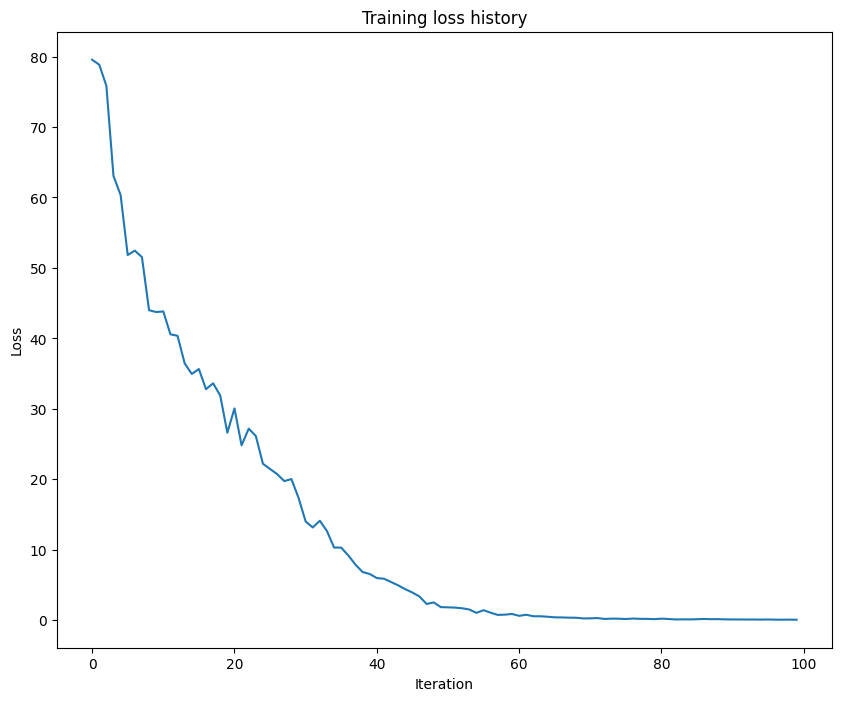

In [70]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
    cell_type='lstm',
    word_to_idx=data['word_to_idx'],
    input_dim=data['train_features'].shape[1],
    hidden_dim=512,
    wordvec_dim=256,
    dtype=np.float32,
)

small_lstm_solver = CaptioningSolver(
    small_lstm_model, small_data,
    update_rule='adam',
    num_epochs=50,
    batch_size=25,
    optim_config={
     'learning_rate': 5e-3,
    },
    lr_decay=0.995,
    verbose=True, print_every=10,
)

start_time = time.time()

small_lstm_solver.train()

training_time = time.time() - start_time

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.1.

In [71]:
print('Final loss: ', small_lstm_solver.loss_history[-1])
print('Training time: %s seconds' % (training_time))

Final loss:  0.07842914079838334
Training time: 80.53967785835266 seconds


## LSTM Sampling at Test Time
Unlike classification models, image captioning models behave very differently at training time vs. at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep and feed the sample as input to the RNN at the next timestep.

<img src="https://drive.google.com/uc?id=1htb-epTDHjBTdC6SbiUuC1AUHiXk0xW7" width="800" height="500"/>

In the code cell [LSTM Captioning Model](https://colab.research.google.com/drive/1SrApwSWX4bgrcoLmpn8lccN1jN2qd3ty?authuser=2#scrollTo=gqZgizaULh_s&line=4&uniqifier=1), implement the `sample` method for test-time sampling of LSTM. After doing so, run the following to sample from your overfitted model on both training and validation data. The samples on training data should be very good. The samples on validation data, however, probably won't make sense (because we're overfitting).

In [39]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

# IQ2: Inline Question 2 (05 points)

In our current image captioning setup, our RNN language model produces a word at every timestep as its output. However, an alternate way to pose the problem is to train the network to operate over _characters_ (e.g. 'a', 'b', etc.) as opposed to words, so that at it every timestep, it receives the previous character as input and tries to predict the next character in the sequence. For example, the network might generate a caption like

'A', ' ', 'c', 'a', 't', ' ', 'o', 'n', ' ', 'a', ' ', 'b', 'e', 'd'

Can you describe one advantage of an image-captioning model that uses a character-level RNN? Can you also describe one disadvantage? HINT: there are several valid answers, but it might be useful to compare the parameter space of word-level and character-level models.

**A.** Advantage: Require less memory, Disadvantage: Larger hidden layers, larger parameter-space and have higher computational costs.

**B.** Advantage: Smaller hidden layers, smaller parameter-space and have lower computational costs, Disadvantage: Require more memory.

**C.** None of the above

**Your Answer:**

```



# Wow! You've conquered half the assignment! 🚀

# Q4: Transformer for Image Captioning (15 points)
As you have seen, RNNs are incredibly powerful but often slow to train. Further, RNNs struggle to encode long-range dependencies (though LSTMs are one way of mitigating the issue). In 2017, Vaswani et al introduced the Transformer in their paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) to a) introduce parallelism and b) allow models to learn long-range dependencies. The paper not only led to famous models like BERT and GPT in the natural language processing community, but also an explosion of interest across fields, including vision. While here we introduce the model in the context of image captioning, the idea of attention itself is much more general.

## Transformer: Multi-Headed Attention (15 points)

### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as

\begin{align}
c = \sum_{i=1}^{n} v_i \alpha_i &\alpha_i = \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

\begin{equation}
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
\end{equation}

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we apply dropout to the attention weights (though in practice it could be used at any step):

\begin{equation}
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)
\end{equation}

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

where $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

Implement multi-headed scaled dot-product attention in the `MultiHeadAttention` class. The code below will check your implementation. The relative error should be less than `e-3`.

In [40]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

In [41]:
class MultiHeadAttention(nn.Module):
    """
    A model layer which implements a simplified version of masked attention, as
    introduced by "Attention Is All You Need" (https://arxiv.org/abs/1706.03762).

    Usage:
      attn = MultiHeadAttention(embed_dim, num_heads=2)

      # self-attention
      data = torch.randn(batch_size, sequence_length, embed_dim)
      self_attn_output = attn(query=data, key=data, value=data)

      # attention using two inputs
      other_data = torch.randn(batch_size, sequence_length, embed_dim)
      attn_output = attn(query=data, key=other_data, value=other_data)
    """

    def __init__(self, embed_dim, num_heads, dropout=0.1):
        """
        Construct a new MultiHeadAttention layer.

        Inputs:
         - embed_dim: Dimension of the token embedding
         - num_heads: Number of attention heads
         - dropout: Dropout probability
        """
        super().__init__()
        assert embed_dim % num_heads == 0

        # We will initialize these layers for you, since swapping the ordering
        # would affect the random number generation (and therefore your exact
        # outputs relative to the autograder). Note that the layers use a bias
        # term, but this isn't strictly necessary (and varies by
        # implementation).
        self.key = nn.Linear(embed_dim, embed_dim)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        
        self.attn_drop = nn.Dropout(dropout)

        self.n_head = num_heads
        self.emd_dim = embed_dim
        self.head_dim = self.emd_dim // self.n_head

    def forward(self, query, key, value, attn_mask=None):
        """
        Calculate the masked attention output for the provided data, computing
        all attention heads in parallel.

        In the shape definitions below, N is the batch size, S is the source
        sequence length, T is the target sequence length, and E is the embedding
        dimension.

        Inputs:
        - query: Input data to be used as the query, of shape (N, S, E)
        - key: Input data to be used as the key, of shape (N, T, E)
        - value: Input data to be used as the value, of shape (N, T, E)
        - attn_mask: Array of shape (S, T) where mask[i,j] == 0 indicates token
          i in the source should not influence token j in the target.

        Returns:
        - output: Tensor of shape (N, S, E) giving the weighted combination of
          data in value according to the attention weights calculated using key
          and query.
        """
        N, S, E = query.shape
        N, T, E = value.shape
        # Create a placeholder, to be overwritten by your code below.
        output = torch.empty((N, S, E))
        ############################################################################
        # TODO: Implement multiheaded attention using the equations given in       #
        # Transformer_Captioning.ipynb.                                            #
        # A few hints:                                                             #
        #  1) You'll want to split your shape from (N, T, E) into (N, T, H, E/H),  #
        #     where H is the number of heads.                                      #
        #  2) The function torch.matmul allows you to do a batched matrix multiply.#
        #     For example, you can do (N, H, T, E/H) by (N, H, E/H, T) to yield a  #
        #     shape (N, H, T, T). For more examples, see                           #
        #     https://pytorch.org/docs/stable/generated/torch.matmul.html          #
        #  3) For applying attn_mask, think how the scores should be modified to   #
        #     prevent a value from influencing output. Specifically, the PyTorch   #
        #     function masked_fill may come in handy.                              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        pass

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return output

In [42]:
expected_self_attn_output, self_attn_output, expected_masked_self_attn_output, masked_self_attn_output, expected_attn_output, attn_output = test_case_multihead_attention(MultiHeadAttention)

print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output.detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output.detach().numpy()))

self_attn_output error:  0.0003775124598178026
masked_self_attn_output error:  0.0001526367643724865
attn_output error:  0.0003527921483788199


In [72]:
# Set the expected error
expected_error = 2.7e-3

# Assert the errors meet the expected error
assert rel_error(expected_self_attn_output, self_attn_output.detach().numpy()) < expected_error
assert rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()) < expected_error
assert rel_error(expected_attn_output, attn_output.detach().numpy()) < expected_error

score += 15
print('Your current score: ', score)

Your current score:  65


## Positional Encoding
While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

**Notes**: Please note that the code for Positional Encoding has already been implemented for your reference.

In [44]:
class PositionalEncoding(nn.Module):
    """
    Encodes information about the positions of the tokens in the sequence. In
    this case, the layer has no learnable parameters, since it is a simple
    function of sines and cosines.
    """
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        """
        Construct the PositionalEncoding layer.

        Inputs:
         - embed_dim: the size of the embed dimension
         - dropout: the dropout value
         - max_len: the maximum possible length of the incoming sequence
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        assert embed_dim % 2 == 0
        # Create an array with a "batch dimension" of 1 (which will broadcast
        # across all examples in the batch).
        pe = torch.zeros(1, max_len, embed_dim)
        ############################################################################
        # TODO: Construct the positional encoding array as described in            #
        # Transformer_Captioning.ipynb.  The goal is for each row to alternate     #
        # sine and cosine, and have exponents of 0, 0, 2, 2, 4, 4, etc. up to      #
        # embed_dim. Of course this exact specification is somewhat arbitrary, but #
        # this is what the autograder is expecting. For reference, our solution is #
        # less than 5 lines of code.                                               #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Get col idx range (i) and powers
        i = torch.arange(max_len)[:, None]
        pows = torch.pow(10000, -torch.arange(0, embed_dim, 2) / embed_dim)

        # Compute positional values sin/cos
        pe[0, :, 0::2] = torch.sin(i * pows)
        pe[0, :, 1::2] = torch.cos(i * pows)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Make sure the positional encodings will be saved with the model
        # parameters (mostly for completeness).
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Element-wise add positional embeddings to the input sequence.

        Inputs:
         - x: the sequence fed to the positional encoder model, of shape
              (N, S, D), where N is the batch size, S is the sequence length and
              D is embed dim
        Returns:
         - output: the input sequence + positional encodings, of shape (N, S, D)
        """
        N, S, D = x.shape
        # Create a placeholder, to be overwritten by your code below.
        output = torch.empty((N, S, D))
        ############################################################################
        # TODO: Index into your array of positional encodings, and add the         #
        # appropriate ones to the input sequence. Don't forget to apply dropout    #
        # afterward. This should only take a few lines of code.                    #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        output = x + self.pe[:, :S]
        output = self.dropout(output)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return output

In [45]:
expected_pe_output, output = test_case_positional_encoding(PositionalEncoding)
print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.00010421011374914356


# Q5: Transformer Captioning Model (20 points)
Now that you have implemented the previous layers, you can combine them to build a Transformer-based image captioning model at the `CaptioningTransformer` class.

Implement the `forward` function of the class. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-5` or less.

In [46]:
import copy

In [47]:
class TransformerDecoderLayer(nn.Module):
    """
    A single layer of a Transformer decoder, to be used with TransformerDecoder.
    """
    def __init__(self, input_dim, num_heads, dim_feedforward=2048, dropout=0.1):
        """
        Construct a TransformerDecoderLayer instance.

        Inputs:
         - input_dim: Number of expected features in the input.
         - num_heads: Number of attention heads
         - dim_feedforward: Dimension of the feedforward network model.
         - dropout: The dropout value.
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(input_dim, num_heads, dropout)
        self.multihead_attn = MultiHeadAttention(input_dim, num_heads, dropout)
        self.linear1 = nn.Linear(input_dim, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, input_dim)

        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.ReLU()


    def forward(self, tgt, memory, tgt_mask=None):
        """
        Pass the inputs (and mask) through the decoder layer.

        Inputs:
        - tgt: the sequence to the decoder layer, of shape (N, T, W)
        - memory: the sequence from the last layer of the encoder, of shape (N, S, D)
        - tgt_mask: the parts of the target sequence to mask, of shape (T, T)

        Returns:
        - out: the Transformer features, of shape (N, T, W)
        """
        # Perform self-attention on the target sequence (along with dropout and
        # layer norm).
        tgt2 = self.self_attn(query=tgt, key=tgt, value=tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        # Attend to both the target sequence and the sequence from the last
        # encoder layer.
        tgt2 = self.multihead_attn(query=tgt, key=memory, value=memory)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        # Pass
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers):
        super().__init__()
        self.layers = clones(decoder_layer, num_layers)
        self.num_layers = num_layers

    def forward(self, tgt, memory, tgt_mask=None):
        output = tgt

        for mod in self.layers:
            output = mod(output, memory, tgt_mask=tgt_mask)

        return output

In [48]:
class CaptioningTransformer(nn.Module):
    """
    A CaptioningTransformer produces captions from image features using a
    Transformer decoder.

    The Transformer receives input vectors of size D, has a vocab size of V,
    works on sequences of length T, uses word vectors of dimension W, and
    operates on minibatches of size N.
    """
    def __init__(self, word_to_idx, input_dim, wordvec_dim, num_heads=4,
                 num_layers=2, max_length=50):
        """
        Construct a new CaptioningTransformer instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries.
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - num_heads: Number of attention heads.
        - num_layers: Number of transformer layers.
        - max_length: Max possible sequence length.
        """
        super().__init__()

        vocab_size = len(word_to_idx)
        self.vocab_size = vocab_size
        self._null = word_to_idx["<NULL>"]
        self._start = word_to_idx.get("<START>", None)
        self._end = word_to_idx.get("<END>", None)

        self.visual_projection = nn.Linear(input_dim, wordvec_dim)
        self.embedding = nn.Embedding(vocab_size, wordvec_dim, padding_idx=self._null)
        self.positional_encoding = PositionalEncoding(wordvec_dim, max_len=max_length)

        decoder_layer = TransformerDecoderLayer(input_dim=wordvec_dim, num_heads=num_heads)
        self.transformer = TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.apply(self._init_weights)

        self.output = nn.Linear(wordvec_dim, vocab_size)

    def _init_weights(self, module):
        """
        Initialize the weights of the network.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, features, captions):
        """
        Given image features and caption tokens, return a distribution over the
        possible tokens for each timestep. Note that since the entire sequence
        of captions is provided all at once, we mask out future timesteps.

        Inputs:
         - features: image features, of shape (N, D)
         - captions: ground truth captions, of shape (N, T)

        Returns:
         - scores: score for each token at each timestep, of shape (N, T, V)
        """
        N, T = captions.shape
        # Create a placeholder, to be overwritten by your code below.
        scores = torch.empty((N, T, self.vocab_size))
        ############################################################################
        # TODO: Implement the forward function for CaptionTransformer.             #
        # A few hints:                                                             #
        #  1) You first have to embed your caption and add positional              #
        #     encoding. You then have to project the image features into the same  #
        #     dimensions.                                                          #
        #  2) You have to prepare a mask (tgt_mask) for masking out the future     #
        #     timesteps in captions. torch.tril() function might help in preparing #
        #     this mask.                                                           #
        #  3) Finally, apply the decoder features on the text & image embeddings   #
        #     along with the tgt_mask. Project the output to scores per token      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # (1) Embed the captions and add positional encoding.
        # shape: [N, T] -> [N, T, W]
        

        # (2) Project image features into the same dimension as the text embeddings.
        # shape: [N, D] -> [N, W] -> [N, 1, W]


        # (3) An additive mask tgt_mask for masking the future.
        # shape: [T, T]
        

        # (4) Apply the Transformer decoder to the caption, allowing it to also
        # attend to image features.
        

        # (5) Project to scores per token.
        # shape: [N, T, W] -> [N, T, V]
        

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return scores

    def sample(self, features, max_length=30):
        """
        Given image features, use greedy decoding to predict the image caption.

        Inputs:
         - features: image features, of shape (N, D)
         - max_length: maximum possible caption length

        Returns:
         - captions: captions for each example, of shape (N, max_length)
        """
        with torch.no_grad():
            features = torch.Tensor(features)
            N = features.shape[0]

            # Create an empty captions tensor (where all tokens are NULL).
            captions = self._null * np.ones((N, max_length), dtype=np.int32)

            # Create a partial caption, with only the start token.
            partial_caption = self._start * np.ones(N, dtype=np.int32)
            partial_caption = torch.LongTensor(partial_caption)
            # [N] -> [N, 1]
            partial_caption = partial_caption.unsqueeze(1)

            for t in range(max_length):

                # Predict the next token (ignoring all other time steps).
                output_logits = self.forward(features, partial_caption)
                output_logits = output_logits[:, -1, :]

                # Choose the most likely word ID from the vocabulary.
                # [N, V] -> [N]
                word = torch.argmax(output_logits, axis=1)

                # Update our overall caption and our current partial caption.
                captions[:, t] = word.numpy()
                word = word.unsqueeze(1)
                partial_caption = torch.cat([partial_caption, word], dim=1)

            return captions

In [75]:
expected_scores, scores = test_case_transformer_captioning(CaptioningTransformer)
print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  5.056720614439509e-06


In [76]:
expected_error = 2.7e-5

assert rel_error(expected_scores, scores.detach().numpy()) < expected_error

score += 20
print('Your current score: ', score)

Your current score:  85


## Overfit Transformer Captioning Model on Small Data
Run the following to overfit the Transformer-based captioning model on the same small dataset as we used for the LSTM previously.

base dir  /content/drive/My Drive/fodl02-assignment02-pphuc/core/datasets/coco_captioning
(Iteration 1 / 100) loss: 5.023862
(Iteration 11 / 100) loss: 2.838943
(Iteration 21 / 100) loss: 1.969206
(Iteration 31 / 100) loss: 1.578370
(Iteration 41 / 100) loss: 1.207552
(Iteration 51 / 100) loss: 1.057950
(Iteration 61 / 100) loss: 0.728378
(Iteration 71 / 100) loss: 0.658365
(Iteration 81 / 100) loss: 0.444065
(Iteration 91 / 100) loss: 0.344296


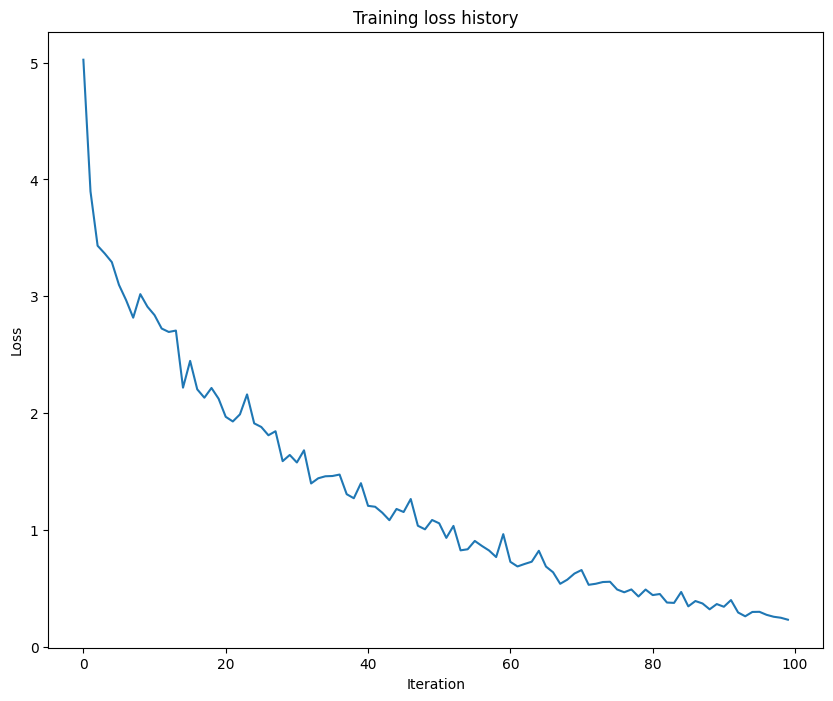

In [83]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

start_time = time.time()

transformer_solver.train()

training_time = time.time() - start_time

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.03.

In [84]:
print('Final loss: ', transformer_solver.loss_history[-1])
print('Training time: %s seconds' % (training_time))

Final loss:  0.2333175
Training time: 17.641483545303345 seconds


# IQ3: Inline Question 3 (05 points)
What is your comment about the training time of the Transformer Captioning Model compared to the LSTM Captioning Model? (Based on following settings: number of epochs is 50, and batch size is 25)

A. LSTM training time is ~5x faster than Transformer.

B. Transformer training time is ~5x faster than LSTM.

C. LSTM and Transformer have compatible training time.

**Your Answer:**

## Transformer Sampling at Test Time
The sampling code has been written for you. You can simply run the following to compare with the previous results with the LSTM. As before the training results should be much better than the validation set results, given how little data we trained on.

URL Error:  Not Found http://farm2.staticflickr.com/1238/1413006689_0ca3c2af54_z.jpg


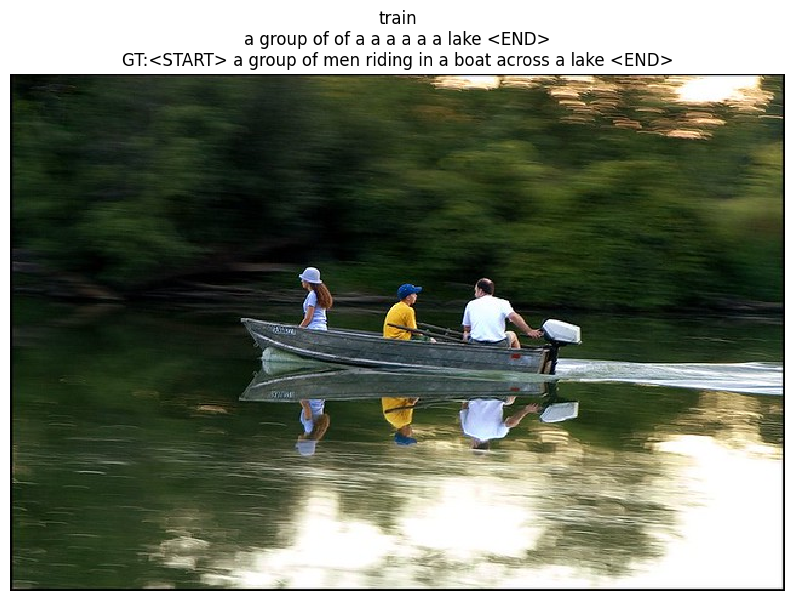

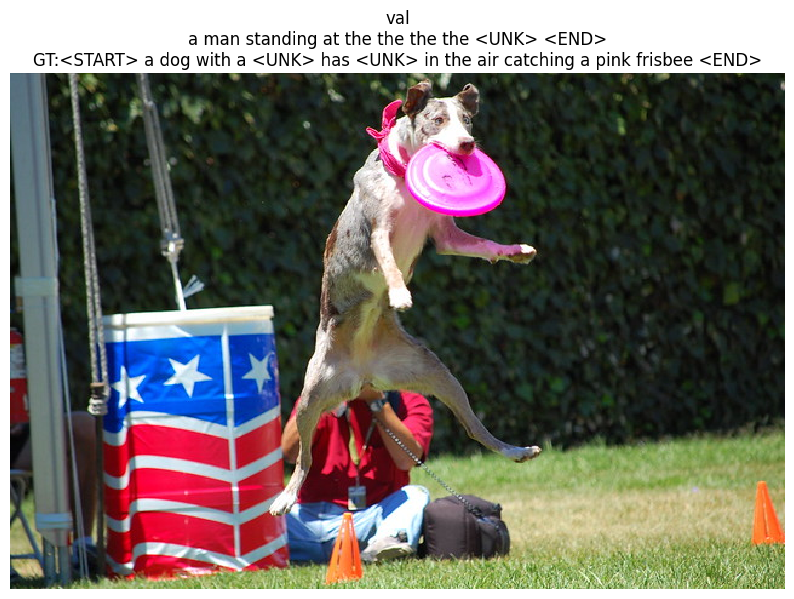

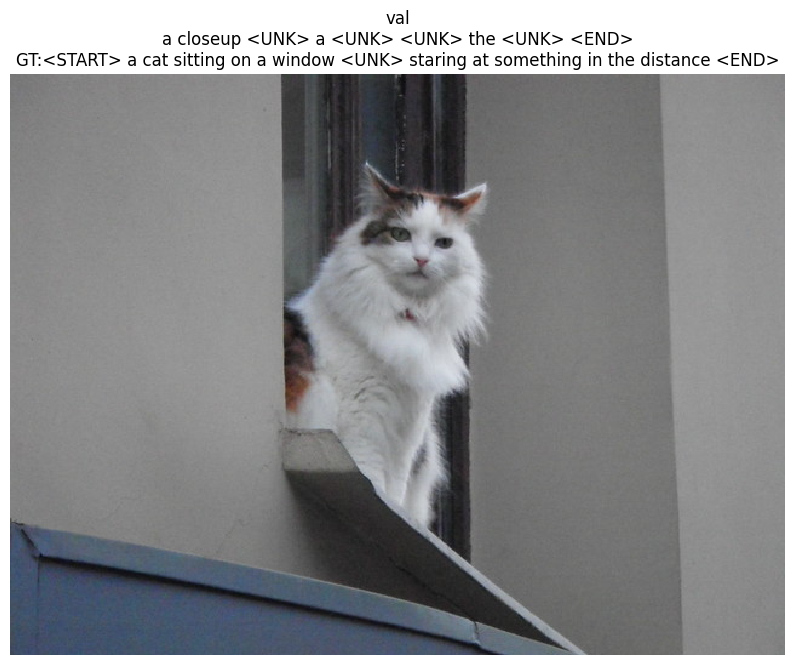

In [53]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

### Your max score will be 85/100, the remaining 15 points are from inline question, which will be graded later

In [85]:
print("Great! Your current score (total 85/100): ", score)

Great! Your current score (total 85/100):  85


# Great work! You have completed all the tasks in this assignment 👏